In [66]:
from traopt_controller import iLQR
from traopt_dynamics import AutoDiffDynamics
from traopt_cost import AutoDiffCost
from matplotlib.animation import FuncAnimation

from jax import random
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from  functools import partial
import math

from IPython.display import HTML

seed = 24234156
key = random.key(seed)

dt = 0.01

In [3]:

def f(x, u):
    g = 9.8 # m/s^2
    m = 2 # kg
    l = 0.1 # m
    
    x1, x2 = x

    if isinstance(u, jnp.ndarray) and (u.shape == (1,)):
        u, = u

    dx1 = x2
    dx2 = - (g / l) * jnp.cos(x1) + (1 / (m * (l**2) )) * u # (u**2)

    return jnp.array([dx1, dx2])


def fd_rk4(x, u, i, dt):
    g = 9.8 # m/s^2
    m = 2 # kg
    l = 0.5 # m

    s1 = f(x,u)
    s2 = f( x+ dt/2*s1, u )
    s3 = f( x+ dt/2*s2, u )
    s4 = f( x+ dt*s3, u )
    x_next = x + dt/6 * ( s1 + 2 * s2 + 2 * s3 + s4 )
    
    return x_next

fd_rk4_dt = partial( fd_rk4, dt = dt )

x_goal = jnp.array([jnp.pi/2, 0])

def l(x,u,i):
    R = 1
    x_diff = x - x_goal
    Q = jnp.diag( jnp.array([1000,50]) )
    return 0.5 * u * R * u + 0.5 * x_diff.T @ Q @ x_diff

def l_terminal(x,i):
    x_diff = x - x_goal
    Q_terminal = jnp.diag( jnp.array([1000,50]) )
    return 0.5 * x_diff.T @ Q_terminal @ x_diff

def on_iteration(iteration_count, xs, us, J_opt, accepted, converged, J_hist):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [8]:
state_size = 2
action_size = 1

dynamics = AutoDiffDynamics( fd_rk4_dt , state_size, action_size, hessians=True ) 

x = random.normal(key, (state_size,))
u = random.normal(key, (action_size,))
i = 1

In [9]:
print("fux = ", dynamics.f_ux(x,u,i))

fux =  [[[1.7962398e-06 8.9707015e-09]]

 [[7.1900367e-04 5.3874937e-06]]]


In [18]:
dynamics.f_ux(x,u,i).shape

(2, 1, 2)

In [17]:
u = np.array([3.])
u.shape
isinstance(u, np.ndarray)

True

In [20]:
cost = AutoDiffCost( l, l_terminal, state_size, action_size )
cost.l(x, u, i, terminal=False)

Array([580.17035], dtype=float32)

In [22]:
a = np.array([[1,3,5,3],[1,3,5,3]])
a.shape[0]

2

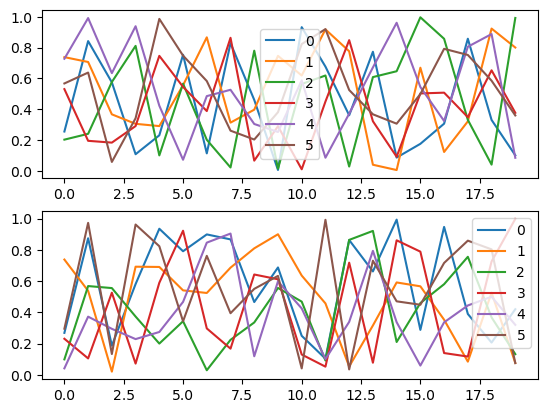

In [70]:
iteration = 6
N = 20
a = np.random.rand(iteration, N, 2)
b = np.random.rand(iteration, N, 2)

fig, axs = plt.subplots(2)
for i in range( a.shape[0] ):
    axs[0].plot( a[i,:,0], label=i )
    axs[1].plot( a[i,:,1], label=i )
axs[0].legend()
axs[1].legend()

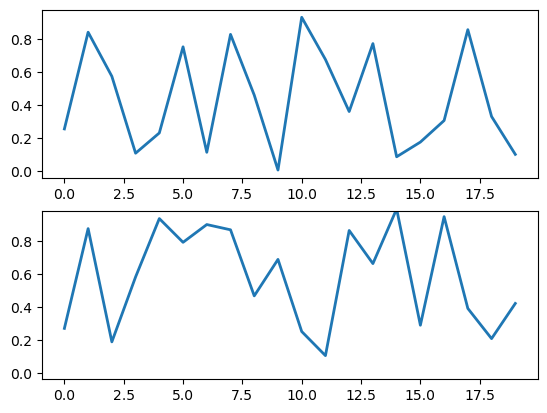

In [73]:
fig, axs = plt.subplots(2, num=6)
line0, = axs[0].plot(a[0,:,0],lw=2)
line1, = axs[1].plot(a[0,:,0],lw=2)

def animation_function(i):
    line0.set_ydata(a[i,:,0])
    line1.set_ydata(a[i,:,1])
    return line0, line1

animation = FuncAnimation(fig,
                      func = animation_function,
                      frames = np.arange(0, iteration), 
                      interval = 500)

# HTML(animation.to_jshtml())


In [74]:
def f(x, u):
    mc = 1
    mp = 1
    l = 1
    g = 9.8
    
    x1, x2, x3, x4 = x
    if (isinstance(u, jnp.ndarray) or isinstance(u, np.ndarray)) and (u.shape == (1,)):
        u, = u

    dx1 = x2
    dx2 = 1/( mc + mp * (jnp.sin(x3)**2) ) * ( u + mp * jnp.sin(x3) * ( l * (x4**2) + g * jnp.cos(x3) ) )
    dx3 = x4
    dx4 = 1/( l*mc + l*mp*(jnp.sin(x3)**2) ) * ( - u*jnp.cos(x3) - mp * l * (x4**2) * jnp.cos(x3) * jnp.sin(x3) - (mc+mp)*g*jnp.sin(x3) )

    return jnp.array([dx1, dx2, dx3, dx4])

def fd_rk4(x, u, i, dt):
    g = 9.8 # m/s^2
    m = 2 # kg
    l = 0.5 # m

    s1 = f(x,u)
    s2 = f( x+ dt/2*s1, u )
    s3 = f( x+ dt/2*s2, u )
    s4 = f( x+ dt*s3, u )
    x_next = x + dt/6 * ( s1 + 2 * s2 + 2 * s3 + s4 )
    
    return x_next

fd_rk4_dt = partial( fd_rk4, dt = dt )

In [75]:
state_size = 4
action_size = 1

x = random.normal(key, (state_size,))
u = random.normal(key, (action_size,))

fd_rk4_dt( x, u, i )

Array([0.2421309 , 1.144117  , 0.09750471, 1.9550617 ], dtype=float32)

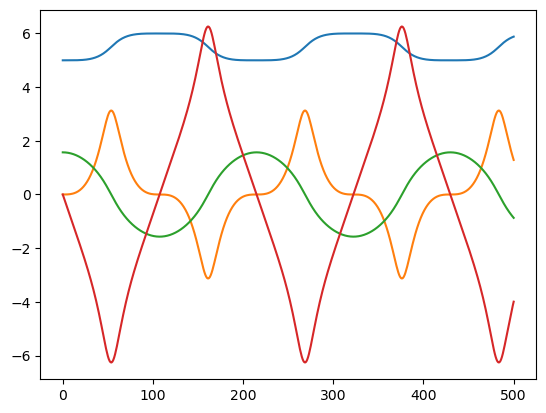

In [76]:
# dynamics simulation

N = 500
x_hist = np.empty( (N+1, state_size) )
x_hist[0] = np.array( [5, 0, math.pi/2, 0] )
u = 0

for i in range(N):
    x_hist[ i+1 ] = fd_rk4_dt( x_hist[ i ], u, i )

plt.figure()
plt.plot(x_hist)

In [44]:
1.1**(-np.arange(10)**2)

array([1.00000000e+00, 9.09090909e-01, 6.83013455e-01, 4.24097618e-01,
       2.17629136e-01, 9.22959982e-02, 3.23491843e-02, 9.37040641e-03,
       2.24320079e-03, 4.43805318e-04])

In [ ]:
N = 200
x_hist = np.empty( (N+1, state_size) )
x_hist[0] = np.array( [5, 0, math.pi/2, 0] )
u = 0

for i in range(N):
    x_hist[ i+1 ] = fd_rk4_dt( x_hist[ i ], u, i )

plt.figure()
plt.plot(x_hist)